In [23]:
import pandas as pd
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


In [5]:
data = pd.read_csv("data/LengthOfStay.csv")
#Removing vdate and dischared variables as they are not need for the model
columns_to_remove = ['vdate','discharged','secondarydiagnosisnonicd9', 'facid']
data = data.drop(columns = columns_to_remove)
#data = data.drop(columns = 'rcount')

# add 'rcount', 'eid' to columns_to_remove

In [6]:
# Identifying missing values if any
missing_values = data.isna().sum()
#missing_values

In [7]:
data.head()

,eid,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,...,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,lengthofstay
0,1,0,F,0,0,0,0,0,0,0,...,11.5,14.20,140.361132,192.476918,12.0,1.390722,30.432418,96,6.5,3
1,2,5+,F,0,0,0,0,0,0,0,...,9.0,4.10,136.731692,94.078507,8.0,0.943164,28.460516,61,6.5,7
2,3,1,F,0,0,0,0,0,0,0,...,8.4,8.90,133.058514,130.530524,12.0,1.065750,28.843812,64,6.5,3
3,4,0,F,0,0,0,0,0,0,0,...,11.9,9.40,138.994023,163.377028,12.0,0.906862,27.959007,76,6.5,1
4,5,0,F,0,0,0,1,0,1,0,...,9.1,9.05,138.634836,94.886654,11.5,1.242854,30.258927,67,5.6,4


Feature Engineering 
## Feature Engineering:
## 1- Standardization: hematocrit, neutrophils, sodium, glucose, bloodureanitro, creatinine, bmi, pulse, respiration.
## 2- Number of preidentified medical conditions: number_of_issues.



In [8]:
from sklearn.preprocessing import OneHotEncoder
# Create an instance of OneHotEncoder
encoder = OneHotEncoder()

# Assuming 'data' is your DataFrame and 'gender' is the column you want to one-hot encode
gender_encoded = encoder.fit_transform(data[['gender']])

# Convert the result to a DataFrame and specify column names
gender_encoded_df = pd.DataFrame(gender_encoded.toarray(), columns=encoder.get_feature_names_out(['gender']))

# Make sure the indices match
gender_encoded_df.index = data.index

# Concatenate the one-hot encoded DataFrame with the original DataFrame
data = pd.concat([data, gender_encoded_df], axis=1)

# Drop the original 'gender' column 
data.drop(columns=['gender'], inplace=True)

# Drop the original 'gender' column 
#data.drop(columns=['gender'], inplace=True)

In [9]:
data.head()

,eid,rcount,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,...,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,lengthofstay,gender_F,gender_M
0,1,0,0,0,0,0,0,0,0,0,...,140.361132,192.476918,12.0,1.390722,30.432418,96,6.5,3,1.0,0.0
1,2,5+,0,0,0,0,0,0,0,0,...,136.731692,94.078507,8.0,0.943164,28.460516,61,6.5,7,1.0,0.0
2,3,1,0,0,0,0,0,0,0,0,...,133.058514,130.530524,12.0,1.065750,28.843812,64,6.5,3,1.0,0.0
3,4,0,0,0,0,0,0,0,0,0,...,138.994023,163.377028,12.0,0.906862,27.959007,76,6.5,1,1.0,0.0
4,5,0,0,0,0,1,0,1,0,0,...,138.634836,94.886654,11.5,1.242854,30.258927,67,5.6,4,1.0,0.0


In [10]:
from sklearn.preprocessing import StandardScaler
# Standardize the specified columns
scaler = StandardScaler()
columns_to_standardize = ['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration']
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])


In [11]:
#Creating a variables that represents the number of issues a patient had. 
# This helps reduce the dimensions for our model

data["number_of_issues"] = data[['hemo', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence',
                                  'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition']].sum(axis=1)

#sums up the values in the specified columns and assigns the result to 'number_of_issues'


In [12]:
data['stay_long'] = (data['lengthofstay'] >= 7).astype(float)

In [13]:
columns_to_drop = ['hemo', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence',
                                  'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition','rcount','eid']
data1 = data.drop(columns=columns_to_drop)

In [14]:
data1.head()

,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,lengthofstay,gender_F,gender_M,number_of_issues,stay_long
0,-0.234247,0.751441,0.823340,1.684186,-0.161915,1.454965,0.312741,1.936991,0.010963,3,1.0,0.0,0,0.0
1,-1.464694,-1.135314,-0.386613,-1.596543,-0.470738,-0.779911,-0.671360,-1.068721,0.010963,7,1.0,0.0,0,1.0
2,-1.760001,-0.238638,-1.611147,-0.381186,-0.161915,-0.167779,-0.480071,-0.811089,0.010963,3,1.0,0.0,0,0.0
3,-0.037375,-0.145235,0.367584,0.713958,-0.161915,-0.961187,-0.921644,0.219441,0.010963,1,1.0,0.0,0,0.0
4,-1.415476,-0.210617,0.247842,-1.569599,-0.200518,0.716587,0.226159,-0.553456,-1.572234,4,1.0,0.0,2,0.0


In [15]:
data1.dtypes

hematocrit          float64
neutrophils         float64
sodium              float64
glucose             float64
bloodureanitro      float64
creatinine          float64
bmi                 float64
pulse               float64
respiration         float64
lengthofstay          int64
gender_F            float64
gender_M            float64
number_of_issues      int64
stay_long           float64
dtype: object

In [16]:
# Splitting the data in to our predictor variables and target variable (Length of stay greater than 7 days)
predictor_variables = ['hematocrit', 'neutrophils', 'sodium','glucose',
                      'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration','gender_F' ,'gender_M','number_of_issues']
X = data1[predictor_variables]
Y = data1['stay_long']

In [17]:
Y.head()

0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: stay_long, dtype: float64

## Splitting data into training and testing set

In [18]:
from sklearn.model_selection import train_test_split 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model Training and Evaluation

## Random Forest

In [26]:
rf_regressor = RandomForestRegressor()

param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf_regressor,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,        # 5-fold cross-validation
    n_jobs=-1,   # Use all available CPU cores
    verbose=1,
    random_state=42
)

# Perform the random search
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Parameters:", random_search.best_params_)

# Print the best cross-validation score
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [20]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the hyperparameter search space
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}


#Create a GradientBoostingRegressor instance
gb_regressor = GradientBoostingRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    gb_regressor,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,        # 5-fold cross-validation
    n_jobs=-1,   # Use all available CPU cores
    verbose=1,
    random_state=42
)

# Perform the random search
random_search.fit(X, y)

# Print the best hyperparameters
print("Best Parameters:", random_search.best_params_)

# Print the best cross-validation score
print("Best Score:", random_search.best_score_)

Mean Absolute Error: 0.23327325391217446


In [ ]:
# Initialize lists to store the results
train_scores = []
test_scores = []
learning_r_values = [0.01, 0.2, 0.3]
# Loop through the 'n_estimators' values and evaluate the model
for n_estimators in learning_r_values:
    # Create and train the model with the current 'n_estimators' value
    model = GradientBoostingRegressor(learning_rate=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate the model on the training set
    train_score = model.score(X_train, y_train)
    train_scores.append(train_score)
    
    # Evaluate the model on the testing set
    test_score = model.score(X_test, y_test)
    test_scores.append(test_score)

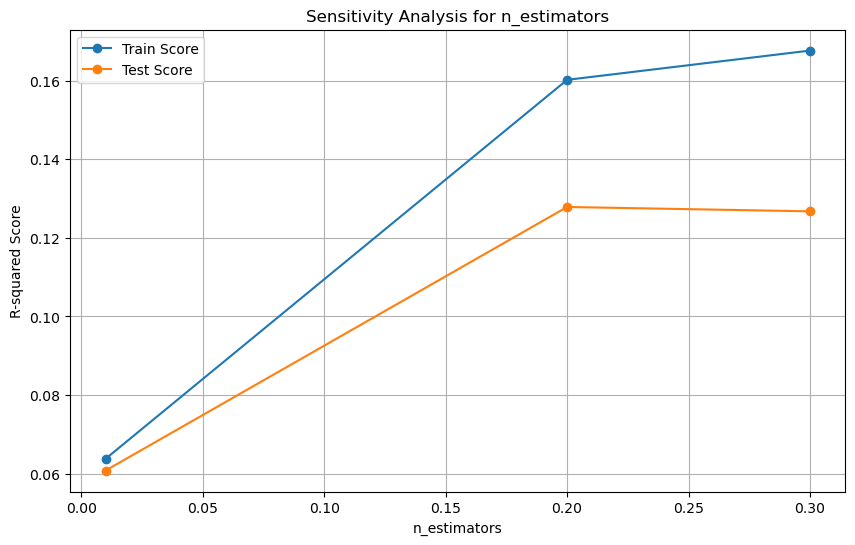

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(learning_r_values, train_scores, label='Train Score', marker='o')
plt.plot(learning_r_values, test_scores, label='Test Score', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('R-squared Score')
plt.title('Sensitivity Analysis for n_estimators')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
gb_regressor1= GradientBoostingRegressor(n_estimators=150, learning_rate=0.2, max_depth=3, random_state=42)

# Fit the model to the training data
gb_regressor1.fit(X_train, y_train)
# Make predictions on the testing data
y_pred1 = gb_regressor1.predict(X_test)
mae2 = mean_absolute_error(y_test, y_pred1)
print(f"Mean Absolute Error: {mae2}")

Mean Absolute Error: 0.23233538116310956


In [ ]:
#Grid Search SV 

from sklearn.model_selection import GridSearchCV
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100,150, 200],
    'max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_